In [229]:
import numpy as np
import pandas as pd
import random
import math

import matplotlib.pyplot as plt
import sklearn.metrics as metrics

from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler  
from sklearn.neighbors import KNeighborsClassifier  

from sklearn import cross_validation
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_validate

from sklearn.model_selection import train_test_split  
from sklearn.model_selection import cross_val_predict

import warnings
warnings.filterwarnings('ignore')

In [288]:
def load_dataset(input_path):
    data = pd.read_csv(input_path)
    shuffle(data, random_state = 210)
    return data

def import_dataset(id):
    if id == 1:
        input_dataset = "Datasets/iris.csv"
    elif id == 2:
        input_dataset = "Datasets/glass.csv"
    elif id == 3:
        input_dataset = "Datasets/wine.csv"
    elif id == 4:
        input_dataset = "Datasets/pima-indians-diabetes.csv"
    else:
        input_dataset = "Datasets/user-knowledge.csv"

    return load_dataset(input_dataset)   

def split_data_on_x_y(dataset):
    X = np.split(dataset, [-1], axis=1)
    y = X[1]
    X = X[0]
    return X, y

def split_data_on_training_test(X, y, test_size):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)
    y_train = np.ravel(y_train)
    y_test = np.ravel(y_test)    
    return X_train, X_test, y_train, y_test

def do_normalization(X, X_train, X_test):
    scaler = StandardScaler()  
    scaler.fit(X)

    X = scaler.transform(X)
    X_train = scaler.transform(X_train)  
    X_test = scaler.transform(X_test)  
    return X, X_train, X_test


In [289]:
def plot_k_neighbor(error, plot_range):
    plt.figure(figsize=(12, 6))  
    plt.plot(plot_range, error, color='red', linestyle='dashed', marker='o',  
             markerfacecolor='blue', markersize=10)
    plt.title('F1 Score K Value')  
    plt.xlabel('K Value')  
    plt.ylabel('F1 Score')  
    
def plot_cross_validation(y1, y2, folds_number):
    plt.style.use('ggplot')

    fig, ax = plt.subplots(figsize=(20, 10))

    ax.set_ylabel('F1-Score')
    ax.set_title('K-Fold vs Stratified K-Fold')

    x = np.arange(len(folds_number))

    width = 0.25
    ax.bar(x, y1, width, label='K-Fold')
    ax.bar(x + width, y2, width,
            color=list(plt.rcParams['axes.prop_cycle'])[2]['color'], label='Stratified K-Fold')
    ax.set_xticks(x + width)
    ax.set_xticklabels(folds_number)
    ax.legend()

    plt.show()
    
def plot_confusion_matrix(Y_test, Y_pred):
    cm = metrics.confusion_matrix(Y_test, Y_pred)
    img = plt.matshow(cm, cmap=plt.cm.Blues)
    plt.colorbar(img, fraction=0.045)
    plt.grid('off')
    for x in range(cm.shape[0]):
        for y in range(cm.shape[1]):
            plt.text(x, y, "%0.2f" % cm[x,y], 
                     size=12,  ha="center", va="center")
    plt.show()


In [418]:
def return_f1_macro_mean_score(scores):
    for key, score in scores.items():
        if key == 'test_f1_macro':
            return np.mean(score)
        
def cross_validation(data, target, cv, k_neighbors, distance = 'manhattan', voting = 'distance', p = 2):
    clf = KNeighborsClassifier(n_neighbors = k_neighbors, weights = voting, metric = distance, p = p)
    scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
    scores = cross_validate(clf, data, target, cv=cv, scoring=scoring, return_train_score=False)
    f1_macro = return_f1_macro_mean_score(scores)
    return f1_macro
    
def do_cross_validation_test(X, y, X_test, y_test, k_neighbors, folds_number = [2, 3, 4, 5, 6, 7, 8, 9]):
    f1_kfold_score = []
    f1_stratified_kfold_score = []

    f1_kfold_score = []
    f1_stratified_kfold_score = []
    print("Neighbor: {}".format(k_neighbors))
    for i in folds_number:
        
        f1_kfold = cross_validation(X, np.ravel(y), KFold(n_splits=i), k_neighbors)
        f1_kfold_score.append(f1_kfold)
        
        f1_stratified_kfold = cross_validation(X, np.ravel(y), StratifiedKFold(n_splits=i), k_neighbors)
        f1_stratified_kfold_score.append(f1_stratified_kfold) 
        
        print("K = {}\t{:.3f}\t{:.3f}".format(i, f1_kfold, f1_stratified_kfold))
        
    plot_cross_validation(f1_kfold_score, f1_stratified_kfold_score, folds_number)

def do_error_test(X, y, X_test, n_fold, K_range = range(1, 31)):
    error = []
    for i in K_range:  
        f1_score = cross_validation(X, np.ravel(y), StratifiedKFold(n_splits=n_fold), i)
        error.append(f1_score)
    
    for index, value in enumerate(error):
        print("{}\t{:.3f}".format(index+1, value ))
    plot_k_neighbor(error, K_range)

def do_distance_count_test(X, y, X_test, n_neighbors, n_fold, metrics):
    print("Neighbor: {}\tFolds: {}".format(n_neighbors, n_fold))
    for metric in metrics:
        f1_score = cross_validation(X, np.ravel(y), StratifiedKFold(n_splits=n_fold), k_neighbors = n_neighbors, 
                                     distance = metric)
        print("\t{}:\t{:.3f}".format(metric, f1_score))
        
def do_vote_test(X, y, X_test, n_neighbors, n_fold, voting):
    print("Neighbor: {}\tFolds: {}".format(n_neighbors, n_fold))
    for vote in voting:
        f1_score = cross_validation(X, np.ravel(y), StratifiedKFold(n_splits=n_fold), k_neighbors = n_neighbors, voting = vote)
        if(hasattr(vote, '__call__')):
            print("\t{}:\t{:.3f}".format(vote.__name__, f1_score))    
        else:
            print("\t{}:\t{:.3f}".format(vote, f1_score))           

def learn_model_and_predict(X_train, y_train, n_fold, n_neighbors = 5, distance = 'minkowski', voting = 'uniform'):
    f1_macro = cross_validation(X_train, np.ravel(y_train), StratifiedKFold(n_splits=n_fold), 
                                   k_neighbors = n_neighbors, voting = voting, distance = distance)
    return f1_macro

def do_distance_vote_test(X, y, X_test, n_neighbors, n_fold, metrics, voting):
    print("Neighbor: {}\tFolds: {}".format(n_neighbors, n_fold))
    
    for metric in metrics:
        res = []
        for vote in voting:
            res.append(cross_validation(X, np.ravel(y), StratifiedKFold(n_splits=n_fold), k_neighbors = n_neighbors, 
                                        voting = vote, distance = metric))
        
        print("\n{}\t".format(metric), end='')
        for i in res:
            print("{:.3f}\t".format(i), end='')      

def random_dist(distance_array):
    shuffle(distance_array, random_state = 210)
    return distance_array

In [428]:
def main(dataset_number, test_size, k_neighbors, n_folds, isActive):

    ######## Preparing Data ########
    
    # Load Data
    dataset = import_dataset(dataset_number)
    
    # Split Data
    X, y = split_data_on_x_y(dataset)
    X_train, X_test, y_train, y_test = split_data_on_training_test(X, y, test_size)
    
    # Normalize Data
    X, X_train, X_test = do_normalization(X, X_train, X_test)
    
    
    ######## Tests ########
    
    
    # Cross Validation Test
    if isActive[0]:
        do_cross_validation_test(X, y, X_test, y_test, k_neighbors) # 3rd parameter = K-Neighbor number
        
    # K Neighbors Test
    if isActive[1]:
        do_error_test(X, y, X_test, n_folds) # 3rd parameter = K-Stratified Fold number
    
    # Distance Count Test
    if isActive[2]:
        do_distance_count_test(X, y, X_test, k_neighbors, n_folds, ['euclidean', 'manhattan', 'chebyshev', 'minkowski'])
    
    # Voting Test
    if isActive[3]:
        do_vote_test(X, y, X_test, k_neighbors, n_folds, ['uniform', 'distance', random_dist])
    
    # Distance and Voting Test
    if isActive[4]:
        do_distance_vote_test(X, y, X_test, k_neighbors, n_folds,
                             ['euclidean', 'manhattan', 'chebyshev', 'minkowski'],
                             ['uniform', 'distance', random_dist])
        
        
    ######## Classificator ########
    
    # Test Classificator
    f1_macro = learn_model_and_predict(X_train, y_train, n_fold = n_folds, n_neighbors = k_neighbors)
        
    # Show results
#     plot_confusion_matrix(y, y_pred)
#     print(classification_report(y, y_pred)) 

Neighbor: 5
K = 2	0.100	0.483
K = 3	0.013	0.570
K = 4	0.144	0.606
K = 5	0.204	0.652
K = 6	0.167	0.630
K = 7	0.197	0.618
K = 8	0.243	0.640
K = 9	0.210	0.626


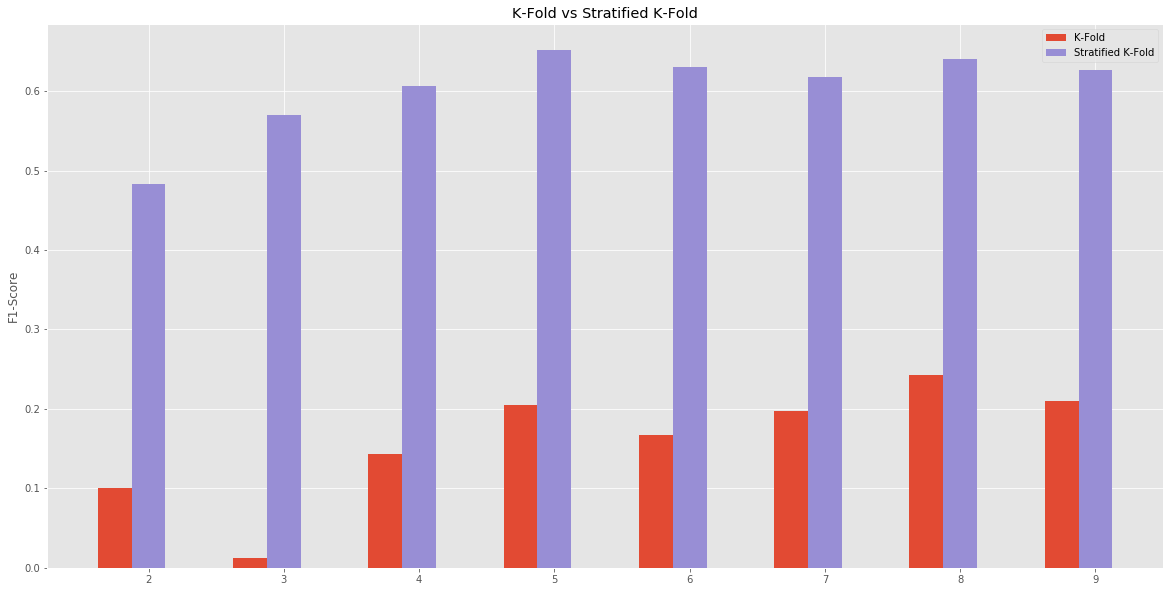

1	0.660
2	0.660
3	0.664
4	0.614
5	0.652
6	0.611
7	0.587
8	0.550
9	0.546
10	0.553
11	0.592
12	0.566
13	0.532
14	0.503
15	0.511
16	0.513
17	0.523
18	0.512
19	0.527
20	0.464
21	0.453
22	0.443
23	0.445
24	0.456
25	0.458
26	0.456
27	0.458
28	0.441
29	0.444
30	0.435
Neighbor: 5	Folds: 5
	euclidean:	0.632
	manhattan:	0.652
	chebyshev:	0.542
	minkowski:	0.632
Neighbor: 5	Folds: 5
	uniform:	0.576
	distance:	0.652
	random_dist:	0.485


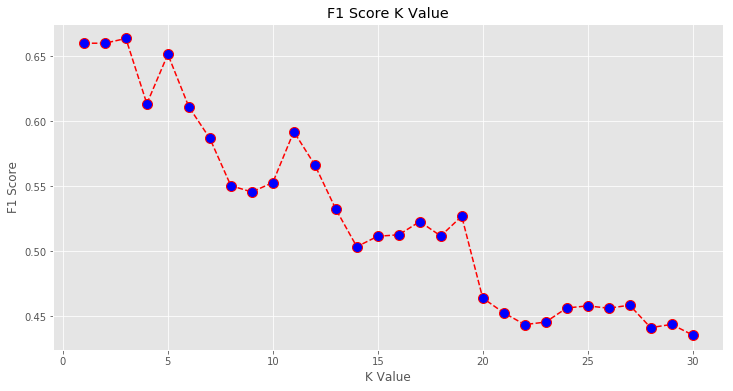

In [427]:
### Datasets ###
# 1. Iris
# 2. Glass
# 3. Wine
# 4. Pima Indians Diabetes
# 5. User Knowledge

### Parameters ###
# 1. Dataset
# 2. Test Size
# 3. K Neighbours
# 4. K Folds
# 5  What is measure -> [x0, x1, x2, x3, x4], where:
     # x0 - Cross Validation
     # x1 - K Value
     # x2 - Distance measure type
     # x3 - Voting measure type
     # x4 - Distance and Voting measure

# main(1, 0.2, 5, 5, [0, 0, 0, 0, 0])
main(2, 0.2, 5, 5, [1, 1, 1, 1, 0])
# main(3, 0.2, 5, 5, [0, 1, 0, 0, 0])
# main(4, 0.2, 17, 5, [0, 1, 0, 0, 0])
# main(5, 0.2, 5, 5, [0, 1, 0, 0, 0])